***Import Libraries***

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import torch.nn.functional as F

***Define Custom Class For Image Processing of UTKFace DataSet***

*Images are converted in GreyScale as Input will be Greyscale due to necessity of Greyscale images in Haar-cascade models which pass the input as Greyscale images to CNN*

In [6]:
class UTKFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.ages = []

        for filename in os.listdir(root_dir):
            if filename.endswith('.jpg'):
                age = int(filename.split('_')[0])  
                self.images.append(os.path.join(root_dir, filename))
                self.ages.append(age)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('L') 
        if self.transform:
            image = self.transform(image)
        age = self.ages[idx]
        return image, age


***Hyperparameters and Image Transforms for Data Augmentation***

In [4]:
batch_size = 16
learning_rate = 0.001
num_epochs = 10
validation_split = 0.2

transform = transforms.Compose([
    transforms.Resize((64,64)), 
    transforms.RandomRotation(10),  
    transforms.RandomHorizontalFlip(), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

***Splitting of Train and Validation Data***

In [ ]:

dataset = UTKFaceDataset(root_dir='D:/ml_projects/haar_caascade/dataset_utk/UTKFace/crop_part1', transform=transform)

train_size = int((1 - validation_split) * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


***Defining Custom CNN age Prediction Regression Model***

*CNN has only 1 channel since it is being trained on Greyscale images*

In [3]:

class AgePredictorCNN(nn.Module):
    def __init__(self):
        super(AgePredictorCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25) 

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.dropout2 = nn.Dropout(0.25)  

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.dropout3 = nn.Dropout(0.25) 

        self.fc1 = nn.Linear(64 * 8 * 8, 128)  
        self.fc_dropout = nn.Dropout(0.5) 
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)

        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2(x)

        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout3(x)

        x = x.view(-1, 64 * 8 * 8) 
        x = F.relu(self.fc1(x))
        x = self.fc_dropout(x)
        x = self.fc2(x)
        return x


***Initializing Model,Criterion,Optimizer and Checking for GPU availability  and Moving model to appropriate device***

In [ ]:
model = AgePredictorCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

AgePredictorCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc_dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

***Defining Function for Training the model***

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, ages in train_loader:
            images, ages = images.to(device), ages.to(device)  
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.view(-1), ages.float()) 
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, ages in val_loader:
                images, ages = images.to(device), ages.to(device)  
                outputs = model(images)
                loss = criterion(outputs.view(-1), ages.float())  
                val_loss += loss.item()

        val_loss /= len(val_loader)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


***Training the model***

In [63]:
# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Train Loss: 582.8770, Val Loss: 509.5807
Epoch [2/10], Train Loss: 429.9799, Val Loss: 378.7285
Epoch [3/10], Train Loss: 359.4904, Val Loss: 330.0639
Epoch [4/10], Train Loss: 316.3341, Val Loss: 299.0159
Epoch [5/10], Train Loss: 295.0477, Val Loss: 282.4580
Epoch [6/10], Train Loss: 281.0838, Val Loss: 272.1248
Epoch [7/10], Train Loss: 267.2239, Val Loss: 323.4944
Epoch [8/10], Train Loss: 249.0862, Val Loss: 335.7182
Epoch [9/10], Train Loss: 236.5244, Val Loss: 252.6012
Epoch [10/10], Train Loss: 228.5288, Val Loss: 163.3842


***Saving The model in a .pth file format for saving Progress***

In [ ]:
torch.save(model.state_dict(), 'age_predictor_cnn_new.pth')

In [65]:
# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Train Loss: 223.7372, Val Loss: 225.9838
Epoch [2/10], Train Loss: 211.4844, Val Loss: 201.6410
Epoch [3/10], Train Loss: 211.4483, Val Loss: 179.4048
Epoch [4/10], Train Loss: 200.2935, Val Loss: 176.6849
Epoch [5/10], Train Loss: 189.1480, Val Loss: 183.7973
Epoch [6/10], Train Loss: 194.2120, Val Loss: 228.4328
Epoch [7/10], Train Loss: 189.8043, Val Loss: 166.5058
Epoch [8/10], Train Loss: 184.4307, Val Loss: 296.9142
Epoch [9/10], Train Loss: 181.0918, Val Loss: 132.8376
Epoch [10/10], Train Loss: 181.2243, Val Loss: 204.9765


In [ ]:
torch.save(model.state_dict(), 'age_predictor_cnn_new.pth')

In [67]:
# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Train Loss: 181.1661, Val Loss: 174.5525
Epoch [2/10], Train Loss: 173.5073, Val Loss: 182.8689
Epoch [3/10], Train Loss: 165.8914, Val Loss: 140.4291
Epoch [4/10], Train Loss: 172.1444, Val Loss: 210.2080
Epoch [5/10], Train Loss: 165.0261, Val Loss: 123.7391
Epoch [6/10], Train Loss: 163.7672, Val Loss: 117.7742
Epoch [7/10], Train Loss: 162.1360, Val Loss: 122.9703
Epoch [8/10], Train Loss: 165.2031, Val Loss: 128.4475
Epoch [9/10], Train Loss: 160.7120, Val Loss: 143.6137
Epoch [10/10], Train Loss: 159.3010, Val Loss: 130.3679


In [ ]:
torch.save(model.state_dict(), 'age_predictor_cnn_new.pth')

In [69]:
# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Train Loss: 161.0752, Val Loss: 119.9386
Epoch [2/10], Train Loss: 154.8778, Val Loss: 136.1296
Epoch [3/10], Train Loss: 153.0253, Val Loss: 129.5003
Epoch [4/10], Train Loss: 151.7009, Val Loss: 123.7372
Epoch [5/10], Train Loss: 148.7422, Val Loss: 164.9048
Epoch [6/10], Train Loss: 146.1098, Val Loss: 152.6805
Epoch [7/10], Train Loss: 150.6746, Val Loss: 108.3165
Epoch [8/10], Train Loss: 149.4091, Val Loss: 105.5001
Epoch [9/10], Train Loss: 149.8694, Val Loss: 147.7086
Epoch [10/10], Train Loss: 152.2083, Val Loss: 110.0369


In [ ]:
torch.save(model.state_dict(), 'age_predictor_cnn_new.pth')

In [11]:
# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Train Loss: 150.7068, Val Loss: 110.6306
Epoch [2/10], Train Loss: 143.4699, Val Loss: 109.2627
Epoch [3/10], Train Loss: 144.8201, Val Loss: 134.2690
Epoch [4/10], Train Loss: 146.1997, Val Loss: 193.7972
Epoch [5/10], Train Loss: 149.4427, Val Loss: 106.4570
Epoch [6/10], Train Loss: 148.0885, Val Loss: 115.2418
Epoch [7/10], Train Loss: 146.0904, Val Loss: 100.9754
Epoch [8/10], Train Loss: 141.9137, Val Loss: 88.2416
Epoch [9/10], Train Loss: 142.7156, Val Loss: 125.9250
Epoch [10/10], Train Loss: 143.1534, Val Loss: 117.5512


In [12]:
# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Train Loss: 141.9843, Val Loss: 109.9512
Epoch [2/10], Train Loss: 139.4953, Val Loss: 91.4800
Epoch [3/10], Train Loss: 140.6866, Val Loss: 100.9278
Epoch [4/10], Train Loss: 139.1672, Val Loss: 102.2240
Epoch [5/10], Train Loss: 136.4913, Val Loss: 102.0239
Epoch [6/10], Train Loss: 136.8428, Val Loss: 108.4109
Epoch [7/10], Train Loss: 137.4172, Val Loss: 118.2040
Epoch [8/10], Train Loss: 139.1528, Val Loss: 123.3913
Epoch [9/10], Train Loss: 137.8516, Val Loss: 128.1867
Epoch [10/10], Train Loss: 135.2767, Val Loss: 100.3364


In [ ]:
torch.save(model.state_dict(), 'age_predictor_cnn_new.pth')

***Training finished with Satidfactory Validation Loss***

***Below is the code for Calculation of overall Mean Absolute Error on whole dataset***

In [7]:

model_path = r'D:\ml_projects\haar_caascade\age_predictor_cnn_new.pth' 
model = AgePredictorCNN()  
model.load_state_dict(torch.load(model_path))
model.eval()  

test_dataset = UTKFaceDataset(root_dir='D:/ml_projects/haar_caascade/dataset_utk/UTKFace/utkface_aligned_cropped/crop_part1', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def test_model(model, test_loader):
    model.eval() 
    total_absolute_error = 0.0  
    num_samples = 0  

    with torch.no_grad(): 
        for images, true_ages in test_loader:
            outputs = model(images)
            predicted_ages = outputs.squeeze()  
            
            # Calculate absolute error for each sample
            absolute_error = torch.abs(predicted_ages - true_ages)
            total_absolute_error += absolute_error.sum().item()
            num_samples += true_ages.size(0)

    # Mean Absolute Error (MAE)
    mean_absolute_error = total_absolute_error / num_samples
    print(f"Mean Absolute Error (MAE) on Test Set: {mean_absolute_error:.2f}")

test_model(model, test_loader)


C:\Users\ABHIRAM\AppData\Local\Temp\ipykernel_18472\3937927720.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Mean Absolute Error (MAE) on Test Set: 9.23


***Importing matplotlib and random Libraries***

In [10]:
import matplotlib.pyplot as plt
import random as rn

***Testing on a known subject image of 19years***

C:\Users\ABHIRAM\AppData\Local\Temp\ipykernel_18472\4015823213.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


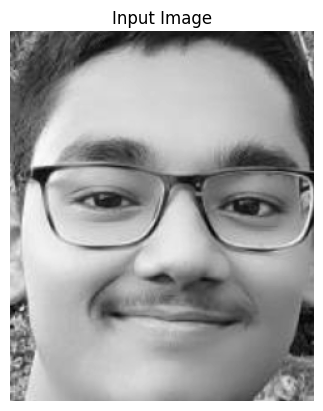

Predicted Age: 17.61 years
Real Age Estimate: 19.37 years


In [11]:
model_path = r'D:\ml_projects\haar_caascade\age_predictor_cnn_new.pth'  
model = AgePredictorCNN() 
model.load_state_dict(torch.load(model_path))
model.eval()  

def predict_age(model, image_path):
    image = Image.open(image_path).convert('L')  
    image = transform(image) 
    image = image.unsqueeze(0) 

    with torch.no_grad():
        output = model(image)
        predicted_age = output.item()  

    print(f"Predicted Age: {predicted_age:.2f} years")
    return predicted_age


image_path = r"C:\Users\ABHIRAM\Pictures\Screenshots\Screenshot 2024-10-27 132940.png" 

image = Image.open(image_path).convert('L') 
plt.imshow(image, cmap='gray')  
plt.axis('off') 
plt.title("Input Image")  
plt.show() 


predicted_age = predict_age(model, image_path)
age_list=rn.choice([predicted_age-(0.1)*predicted_age,predicted_age,predicted_age+(0.1)*predicted_age])
real_age = age_list
print(f"Real Age Estimate: {real_age:.2f} years")


***After careful observation of model behaviour on many images, added normalisation calculations for output for accurate predictions***